In [1]:
import os
import json
from pathlib import Path
import openai
import pandas as pd
import numpy as np
import logging
from IPython.display import clear_output
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt
import re

%matplotlib inline
%load_ext autoreload
%autoreload 2

from parse import parse

from finetuning import prepare_data
from utils import graph
from utils import utils
from nodes.node_functions import *
from utils.models_metadata import *

# playground

In [2]:
model_metadata, model_version = get_model_metadata("validate_why_applicant_picked_X_over_Y")

In [3]:
model_metadata.keys()

dict_keys(['prompt_template', 'completion_template', 'nested_completion_templates', 'kshot_header', 'finetuned_model_name', 'stop_sequence', 'model_name', 'model_version'])

In [10]:
completion_args = dict(validation_of_response="1",
    applicant_justifications="""Subpoint: <Binary Encoding requires fewer columns to encode a categorical variable than One Hot Encoding.><1><NA>
Subpoint: <Tree-based models perform better with fewer columns.><1><NA>""",
    num_correct_subpoints="2", 
    num_incorrect_subpoints="0", 
    num_irrelevant_subpoints="0")

In [11]:
completion = model_metadata['completion_template'].format(**completion_args)
print(completion)

Validation of response: 1
Applicant justifications:
Subpoint: <Binary Encoding requires fewer columns to encode a categorical variable than One Hot Encoding.><1><NA>
Subpoint: <Tree-based models perform better with fewer columns.><1><NA>
Number of correct, incorrect, irrelevant subpoints: 2, 0, 0



In [12]:
res = utils.parse_completion_args(completion, model_metadata)
res

{'validation_of_response': '1',
 'applicant_justifications': [{'subpoint': 'Binary Encoding requires fewer columns to encode a categorical variable than One Hot Encoding.',
   'validation_of_subpoint': '1',
   'reason_for_validation': 'NA'},
  {'subpoint': 'Tree-based models perform better with fewer columns.',
   'validation_of_subpoint': '1',
   'reason_for_validation': 'NA'}],
 'num_correct_subpoints': '2',
 'num_incorrect_subpoints': '0',
 'num_irrelevant_subpoints': '0'}

In [14]:
reconstructed_completion = utils.prepare_completion_using_nested_args(res, model_metadata)
print(reconstructed_completion)
assert completion == reconstructed_completion

Validation of response: 1
Applicant justifications:
Subpoint: <Binary Encoding requires fewer columns to encode a categorical variable than One Hot Encoding.><1><NA>
Subpoint: <Tree-based models perform better with fewer columns.><1><NA>
Number of correct, incorrect, irrelevant subpoints: 2, 0, 0



In [9]:
chat_history_by_section

[["Interviewer: Thank you for taking the time out to interview with us. \n    In this interview, we will cover a range of topics and ask questions to assess your skill level as a Data Scientist. \n    If you don't understand a question, feel free to ask questions to get clarification.\n    Let's get started."],
 ['Interviewer: Could you confirm whether you used a Generative Adversarial Network for this task?',
  'Applicant: Yes, I used a Generative Adversarial Network for this task.',
  'Interviewer: How does a Generative Adversarial Network work?',
  'Applicant: GANs are deep learning models that produce fake data.',
  'Interviewer: Besides GANs, did you consider any other algorithms for this task?',
  'Applicant: Yes, I considered using autoencoders and also CNNs.']]

In [11]:
# interview_graph.nodes["algorithm selection"]['graph'].nodes['ask_how_it_works']['function_args']['subject'] = "DBSCAN"

current_node = interview_graph.nodes["algorithm selection"]['graph'].nodes["validate_why_applicant_picked_X_over_Y"]

current_node_function_args = deepcopy(current_node['function_args']) if 'function_args' in current_node else {}
current_node_function_args['carryover_data'] = carryover_data
current_node_function_args['current_section_name'] = "algorithm selection"
current_node_function_args['validate_async'] = False
current_node_function_args['chat_history_by_section'] = chat_history_by_section

current_node_output = current_node['function'](**current_node_function_args)


******************
********* Model Name *********
validate_why_applicant_picked_X_over_Y
********* Prompt *********
Context:
What interviewer thinks applicant did:
{'algorithm selection': 'GAN', 'categorical encoding': 'hash encoding', 'handling numerical variables': 'robust scaler'}

Objectives/Contraints:
- Maximize model performance.
- Model interpretability is not a strong requirement.


Current section chat:
Interviewer: Could you confirm whether you used a Generative Adversarial Network for this task?
Applicant: Yes, I used a Generative Adversarial Network for this task.
Interviewer: How does a Generative Adversarial Network work?
Applicant: GANs are deep learning models that produce fake data.
Interviewer: Besides GANs, did you consider any other algorithms for this task?
Applicant: Yes, I considered using autoencoders and also CNNs.

Details:
Is validation correct: 1
###

********* Completion *********
Validation of response: 1
Applicant justifications:
[{'subpoint': 'GANs are

ValueError: Length of values (0) does not match length of index (1)

# setup

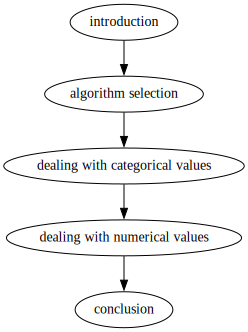

In [2]:
interview_graph = graph.create_interview_flowchart()

graph.plot_graph(interview_graph)

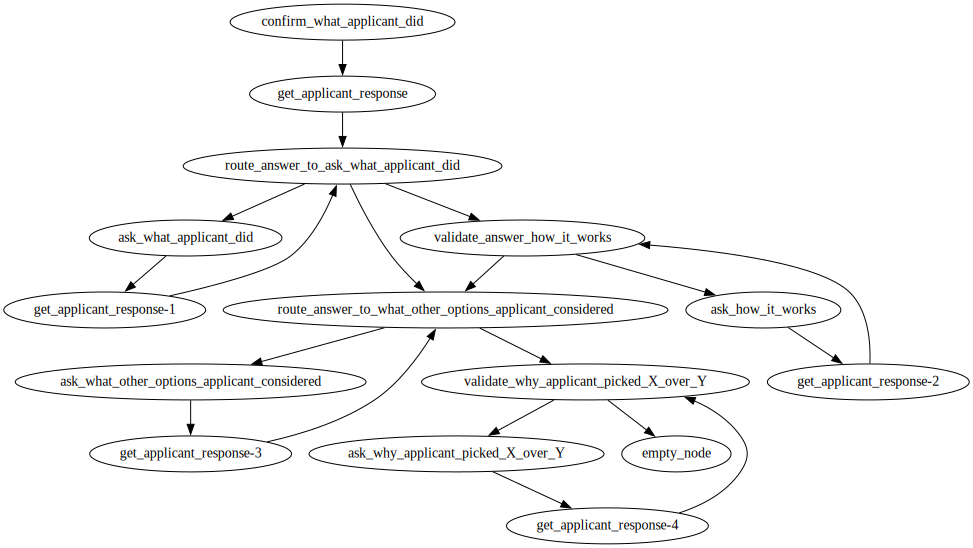

In [3]:
graph.plot_graph(interview_graph.nodes["algorithm selection"]['graph'])

graph.plot_graph(interview_graph.nodes["dealing with categorical values"]['graph'])

graph.plot_graph(interview_graph.nodes["dealing with numerical values"]['graph'])

# run

In [4]:
applicant_approaches = {
    'algorithm selection': 'GAN',
    'categorical encoding': 'hash encoding',
    'handling numerical variables': 'robust scaler'
}

In [5]:
data_challenge_objectives_and_contraints = """- Maximize model performance.
- Model interpretability is not a strong requirement."""

In [6]:
what_interviewer_thinks_applicant_has_done_in_ipynb = deepcopy(applicant_approaches)
# update what_interviewer_thinks_applicant_has_done_in_ipynb here

graph.add_function_arg_to_node(interview_graph.nodes["algorithm selection"]['graph'].nodes['confirm_what_applicant_did'],
                        'context',
                         what_interviewer_thinks_applicant_has_done_in_ipynb
                        )
graph.add_function_arg_to_node(interview_graph.nodes["dealing with categorical values"]['graph'].nodes['confirm_what_applicant_did'],
                        'context',
                         what_interviewer_thinks_applicant_has_done_in_ipynb
                        )
graph.add_function_arg_to_node(interview_graph.nodes["dealing with numerical values"]['graph'].nodes['confirm_what_applicant_did'],
                        'context',
                         what_interviewer_thinks_applicant_has_done_in_ipynb
                        )

In [7]:
carryover_data = {
    "applicant_data": {"applicant_skill_summary": {"technical_depth": np.random.randint(1, 4),
                                                "technical_breadth": np.random.randint(1, 4),
                                                "critical_thinking": np.random.randint(1, 4)},
                       "applicant_context": applicant_approaches,
                      },
    "what_interviewer_thinks_applicant_has_done_in_ipynb": what_interviewer_thinks_applicant_has_done_in_ipynb,
    "data_challenge_objectives_and_contraints": data_challenge_objectives_and_contraints,
}

# each list within this variable is the conversation in a particular section. each string within that list is the ordered dialogue from each member of the interview
chat_history_by_section = []
flattened_chat_history = ""

# list of the nodes that have been visited till the current point
sections_visited_names = []
nodes_visited_names = []

validate_async = False
is_interview_complete = False


current_section_name, current_section = graph.get_first_node_in_graph(interview_graph)
current_section_graph = current_section['graph']

In [8]:


# traverse through sections
while not is_interview_complete:
    chat_history_by_section.append([])
    current_node_name, current_node = graph.get_first_node_in_graph(current_section_graph)
    # print("\n\ncurrent section: " + current_section_name)
    # print("current node: " + current_node_name)
    is_section_complete = False
    # traverse within section
    while not is_section_complete:
        # access current node from current section
        # prep args for current node function
        current_node_function_args = deepcopy(current_node['function_args']) if 'function_args' in current_node else {}
        current_node_function_args['current_section_name'] = current_section_name
        current_node_function_args['carryover_data'] = carryover_data
        current_node_function_args['validate_async'] = validate_async
        current_node_function_args['chat_history_by_section'] = chat_history_by_section

        # call function
        current_node_output = current_node['function'](**current_node_function_args)
        
        if current_node_output['new_chat_lines']:
            # store return values in appropriate variables (chat_history)
            chat_history_by_section[-1].extend(current_node_output['new_chat_lines'])
            flattened_chat_history += "\n" + "\n".join(current_node_output['new_chat_lines'])
            clear_output()
            print(flattened_chat_history)
    
        # update nodes_visited
        nodes_visited_names.append(current_node_name)
    
        # figure out next node to visit
        current_node_name, current_node = graph.get_next_node(current_section_graph, current_node_name, current_node_output)
        if current_node_name is None:
            # prepare routing_value (result of a section)
            current_section_output = dict(routing_value=1, 
                                          new_chat_line=None) 
            is_section_complete = True

    
    sections_visited_names.append(current_section_name)
    # get new section
    current_section_name, current_section = graph.get_next_node(interview_graph, current_section_name, current_section_output)
    if current_section_name is None:
        is_interview_complete = True
        break
    current_section_graph = current_section['graph']



******************
********* Model Name *********
route_answer_to_what_other_options_applicant_considered
********* Prompt *********
Current section chat:
Interviewer: Could you confirm whether you used a Generative Adversarial Network for this task?
Applicant: Yes, I used a Generative Adversarial Network for this task.
Interviewer: How does a Generative Adversarial Network work?
Applicant: GANs are deep learning models that produce fake data.
Interviewer: Besides GANs, did you consider any other algorithms for this task?
Applicant: Yes, I considered using autoencoders and also CNNs.

Details:
Is routing correct: 1
###

********* Completion *********
Route: 1
******************



ValueError: invalid literal for int() with base 10: ''

In [11]:
# prepare_data.validate_observations_for_finetuning_from_queue()